<a href="https://colab.research.google.com/github/tinemyumi/saude-mental-datasus/blob/main/analytics-workbench/modelos_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Relatório**

**Integrantes**
- Larissa Yumi Tinem
- Leo Tsuchida Hoçoya

**Conteúdo**

- Pré-processamento de dados
- Construção da base de DRS (Divisão Regional de Saúde)
- Criação de indicadores (internação por 100K, caps por 100K)
- Modelos de ML

**Histórico de alterações:**
- 14/11/2025 - Larissa Yumi Tinem - Pré-processamento, construção do df e criação de indicadores
- 16/11/2025 - Larissa Yumi Tinem - ML e interpretação

# **Análise de Internações, CAPS e Regiões de Saúde – Estado de São Paulo**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Importação das bibliotecas**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

## **Configuração de visualização**

In [3]:
# Configurações de visualização
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


## **Carregamento dos dados**

In [4]:
df_sih = pd.read_csv('/content/drive/MyDrive/Dataframes/df_tratado.csv')
df_caps = pd.read_csv('/content/drive/MyDrive/Dataframes/df_caps_sp.csv')
df_populacao = pd.read_csv('/content/drive/MyDrive/Dataframes/df_populacao_sp.csv')
df_regioes = pd.read_csv('/content/drive/MyDrive/Dataframes/cod_regioes.csv')

## **Padronização do código do município (cod_mun6)**

Nessa seção é padronizado o código identificador dos municípios (cod_mun6) em todos os dataframes para garantir que todos os dataframes usem o mesmo formato de código para permitir merges e análises consistentes.

In [5]:
# --- df_sih ---
df_sih['cod_mun6'] = df_sih['MUNIC_MOV'].astype(str)
df_sih['cod_mun6'] = df_sih['cod_mun6'].str[:6].astype(int)

# --- df_caps ---
df_caps['cod_mun6'] = df_caps['CO_IBGE'].astype(str)
df_caps['cod_mun6'] = df_caps['cod_mun6'].str[:6].astype(int)

# --- df_pop ---
df_populacao['cod_mun6'] = df_populacao['COD_MUN_6'].astype(str)
df_populacao['cod_mun6'] = df_populacao['cod_mun6'].str[:6].astype(int)

# --- df_regioes ---
df_regioes['cod_mun6'] = df_regioes['cod_ibge'].astype(str)
df_regioes['cod_mun6'] = df_regioes['cod_mun6'].str[:6].astype(int)



## **Construção da Base Integrada**

O objetivo é gerar tabelas resumidas por município com número de internações, quantidade de CAPS e população, para facilitar análises posteriores.

In [6]:
# Internações por município
internacoes_mun = (
    df_sih.groupby('cod_mun6')
    .size()
    .reset_index(name='quantidade_internacoes')
)

# Caps por município
caps_mun = (
    df_caps.groupby('cod_mun6')
    .size()
    .reset_index(name='quantidade_caps')
)

# Tabela de população por município
populacao_mun = df_populacao[['cod_mun6', 'name_municipality', 'population']]

### **Mapeamento de Município: Regiões de Saúde (DRS)**

Aqui, o objetivo é associar cada município à sua respectiva região (DRS), criando uma tabela que relaciona o código do município com a região correspondente.

A análise será feita no nível de DRS para identificar padrões regionais, não de munícipio.

In [7]:
regioes = df_sih.merge(
    df_regioes,
    left_on='cod_mun6',
    right_on='cod_mun6',
    how='left'
)


In [8]:
regioes = df_regioes[['cod_mun6', 'drs']]


### **Base integrada Final (merge dos 4 datasets)**

Aqui é criada a base final unindo regiões, internações, CAPS e população por município usando o cod_mun6. Depois, substitui-se valores faltantes por 0 e deixa tudo como inteiro pra manter a base consistente.

**Variáveis finais:**
- cod_mun6
- drs
- quantidade_internacoes
- quantidade_caps
- name_municipality
- population

In [9]:
df_base = (
    df_regioes[['cod_mun6', 'drs']]
        .merge(internacoes_mun, on='cod_mun6', how='left')
        .merge(caps_mun, on='cod_mun6', how='left')
        .merge(populacao_mun, on='cod_mun6', how='left')
)

df_base['quantidade_caps'] = df_base['quantidade_caps'].fillna(0).astype(int)
df_base['quantidade_internacoes'] = df_base['quantidade_internacoes'].fillna(0).astype(int)
print(f"Base integrada criada: {len(df_base)} municípios")


Base integrada criada: 645 municípios


## **Nova variável: Municípios que contêm CAPS**

Aqui é identificado os municípios que possuem pelo menos 1 CAPS para analisar diferenças entre municípios com/sem CAPS.

In [10]:
df_base["tem_caps"] = (df_base["quantidade_caps"] >= 1).astype(int)


### **Internações e População Por DRS**

In [12]:
print("\nINTERNAÇÕES POR DRS")
print(df_base.groupby('drs')['quantidade_internacoes'].sum().sort_values(ascending=False))

print("\nPOPULAÇÃO POR DRS")
print(df_base.groupby('drs')['population'].sum().sort_values(ascending=False))


INTERNAÇÕES POR DRS
drs
DRS Grande São Paulo         79295
DRS São João da Boa Vista    37773
DRS Campinas                 23697
DRS Marília                  20426
DRS São José do Rio Preto    17864
DRS Bauru                    16513
DRS Presidente Prudente      12076
DRS Ribeirão Preto           11613
DRS Taubaté                   9548
DRS Sorocaba                  7555
DRS Piracicaba                7459
DRS Franca                    6841
DRS Baixada Santista          5419
DRS Araraquara                4364
DRS Araçatuba                 3487
DRS Barretos                  1494
DRS Registro                   328
Name: quantidade_internacoes, dtype: int64

POPULAÇÃO POR DRS
drs
DRS Grande São Paulo         20731920
DRS Campinas                  4627859
DRS Sorocaba                  2549954
DRS Taubaté                   2505723
DRS Baixada Santista          1805531
DRS Bauru                     1733827
DRS São José do Rio Preto     1640035
DRS Piracicaba                1554738
DRS Ribeir

## **Indicadores-chave**

### **Taxas por 100K Habitantes (Nível DRS)**

O objetivo é calcular as duas métricas principais que serão usadas no clustering:
- Taxa de internações por 100k habitantes
- Taxa de CAPS por 100k habitantes


**Resultado observado:**

- Regiões como São João da Boa Vista e Marília têm taxas extremamente altas, sugerindo forte concentração de internações e possível papel como polos regionais.

- A Grande São Paulo apresenta taxa baixa, provavelmente devido à oferta mais diversificada de serviços.

- Registro tem a menor taxa do estado, o que pode indicar desde baixa demanda até ausência de estrutura e deslocamento de pacientes para outras regiões.

In [14]:
taxa_drs = (
    df_base
        .groupby('drs')[['quantidade_internacoes', 'population']]
        .sum()
        .assign(taxa_inter_100k=lambda d: d['quantidade_internacoes'] / d['population'] * 100000)
)

print("\nTAXA DE INTERNAÇÕES POR 100K - RANKING DRS")
print(taxa_drs.sort_values('taxa_inter_100k', ascending=False))


TAXA DE INTERNAÇÕES POR 100K - RANKING DRS
                           quantidade_internacoes  population  taxa_inter_100k
drs                                                                           
DRS São João da Boa Vista                   37773      804426      4695.646337
DRS Marília                                 20426     1104009      1850.166077
DRS Presidente Prudente                     12076      746402      1617.894915
DRS São José do Rio Preto                   17864     1640035      1089.245047
DRS Franca                                   6841      683846      1000.371429
DRS Bauru                                   16513     1733827       952.401826
DRS Ribeirão Preto                          11613     1464774       792.818551
DRS Campinas                                23697     4627859       512.051037
DRS Piracicaba                               7459     1554738       479.759291
DRS Araçatuba                                3487      759557       459.083387
DRS Arar

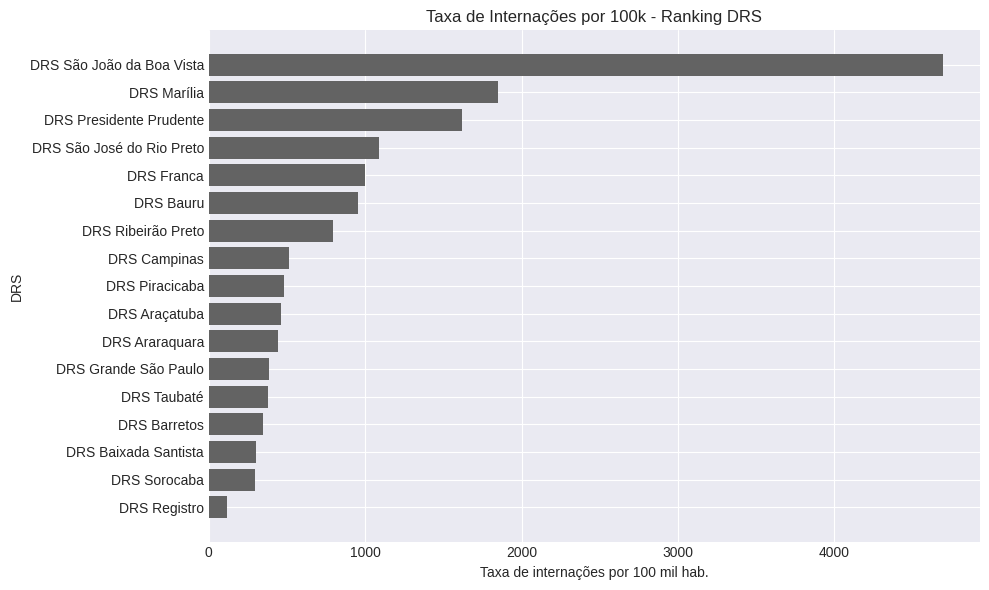

In [15]:
# Gráfico Taxa de Internações por 100K

plot_df = taxa_drs.sort_values('taxa_inter_100k', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(plot_df.index.astype(str), plot_df['taxa_inter_100k'], color='#636363')

plt.xlabel("Taxa de internações por 100 mil hab.")
plt.ylabel("DRS")
plt.title("Taxa de Internações por 100k - Ranking DRS")
plt.tight_layout()
plt.show()



## **Clusterização: Preparação dos Dados (Agregação Por DRS)**

Objetivo: Criar dataset final em nível de DRS (não município) com todas as métricas necessárias para o K-means

**Variáveis:**
- **internacoes_100k:** taxa de internações por 100K habitantes
- **caps_100k:** taxa de CAPS por 100K habitantes


In [16]:
df_drs = df_base.groupby('drs').agg({
    'quantidade_internacoes': 'sum',
    'population': 'sum',
    'quantidade_caps': 'sum'
}).reset_index()

# Criar métricas por 100k
df_drs['internacoes_100k'] = df_drs['quantidade_internacoes'] / df_drs['population'] * 100000
df_drs['caps_100k'] = df_drs['quantidade_caps'] / df_drs['population'] * 100000

print(f"✅ {len(df_drs)} DRS processadas")


✅ 17 DRS processadas


## **Análise de Correlação**

O objetivo aqui é verificar se há relação entre número de CAPS e taxa de internações

**Interpretação esperada:**
- **Correlação negativa forte:** mais CAPS -> menos internações (substitutividade)
- **Correlação positiva:** mais CAPS estão onde há mais demanda (polos)
- **Correlação fraca:** não há relação clara

In [17]:
print("\nAnálise de Correlação:")
correlacao = df_drs['caps_100k'].corr(df_drs['internacoes_100k'])
print(f"Correlação CAPS/100k vs Internações/100k: {correlacao:.3f}")


Análise de Correlação:
Correlação CAPS/100k vs Internações/100k: 0.629


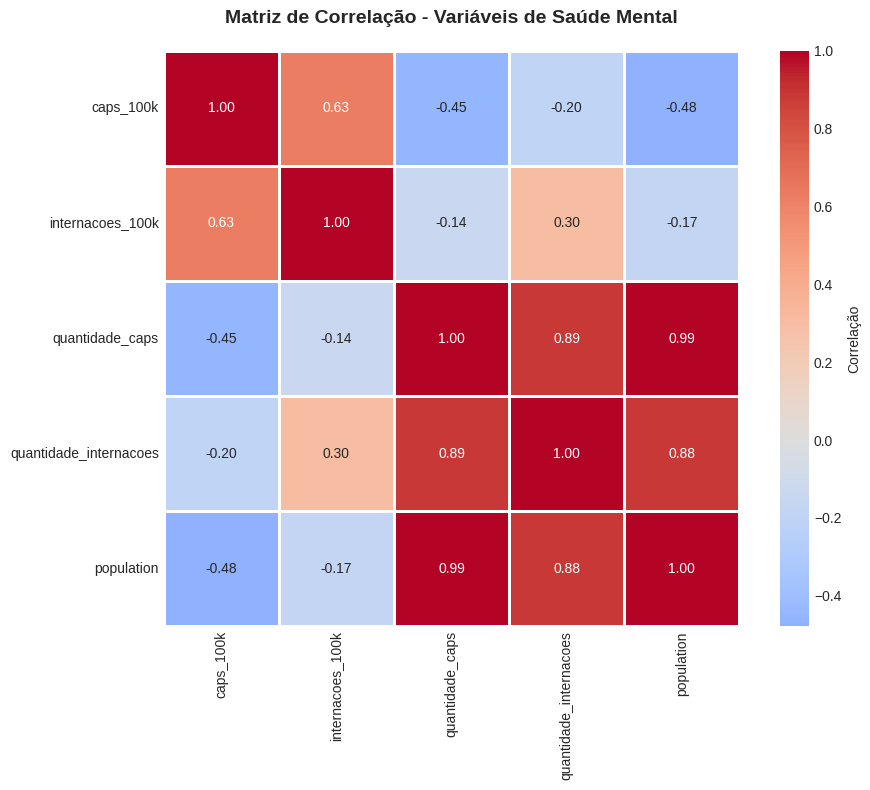

In [18]:
# Matriz de correlação completa
correlation_vars = df_drs[['caps_100k', 'internacoes_100k', 'quantidade_caps',
                            'quantidade_internacoes', 'population']]

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_vars.corr(), annot=True, cmap='coolwarm',
            center=0, fmt='.2f', square=True, linewidths=1, cbar_kws={'label': 'Correlação'})
plt.title('Matriz de Correlação - Variáveis de Saúde Mental', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

## **Detecção de Outliers (Z-SCORE)**

O objetivo é identificar DRS com valores extremos que possam influenciar o clustering.

O método Z-Score > 2 indica valor muito acima/abaixo da média.

In [19]:
print("\n⚠️  Detecção de Outliers (Z-score > 2):")

df_drs['z_caps'] = np.abs(stats.zscore(df_drs['caps_100k']))
df_drs['z_internacoes'] = np.abs(stats.zscore(df_drs['internacoes_100k']))

outliers = df_drs[(df_drs['z_caps'] > 2) | (df_drs['z_internacoes'] > 2)]
if len(outliers) > 0:
    print(outliers[['drs', 'caps_100k', 'internacoes_100k', 'z_caps', 'z_internacoes']])
else:
    print("Nenhum outlier extremo detectado.")


⚠️  Detecção de Outliers (Z-score > 2):
                          drs  caps_100k  internacoes_100k    z_caps  \
15  DRS São João da Boa Vista   2.859182       4695.646337  2.247862   

    z_internacoes  
15       3.587514  


## **Preparação para Clustering: Padronização das Variáveis**

**Objetivo:**

Normalizar as features (caps_100k e internacoes_100k) para que tenham média 0 e desvio padrão 1, pois K-means é sensível à escala das variáveis. Sem padronização, variáveis com valores maiores teriam peso desproporcional.

In [20]:
from sklearn.preprocessing import StandardScaler

X = df_drs[['caps_100k', 'internacoes_100k']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


### **Validação do número de clustering: Método do Cotovelo**

- Identificação do número ideal de clusters (K)
- Método: avaliar a inércia (WCSS) para K de 2 a 7
  - Procurar o "cotovelo" no gráfico onde a queda da inércia desacelera.

**Resultado:**

O ponto de dobra em X = 3 indica o número ideal de clusters


📐 Método do Cotovelo - Determinando K ideal


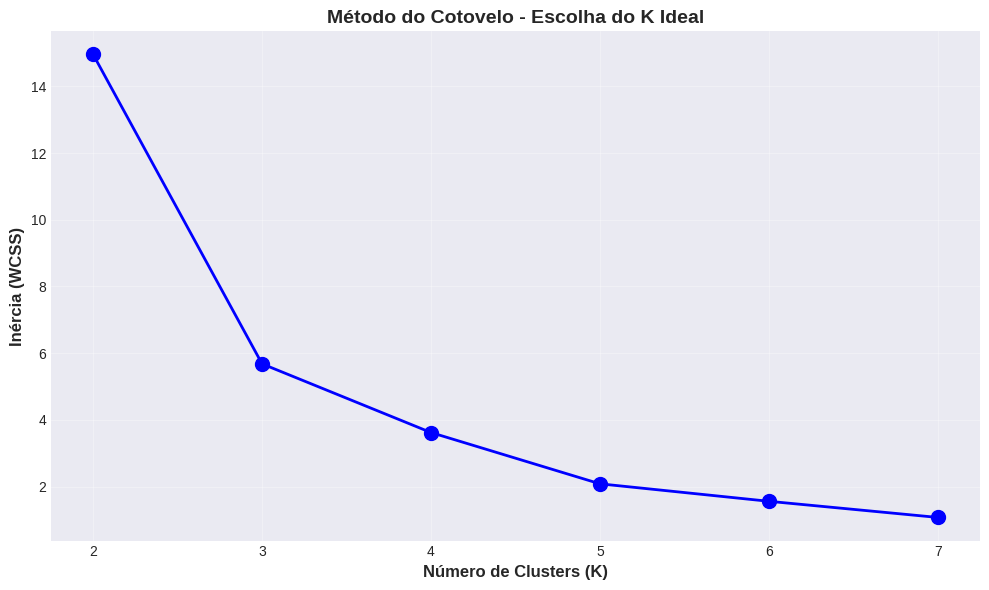

In [21]:
print("\n📐 Método do Cotovelo - Determinando K ideal")

inertias = []
K_range = range(2, 8)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=10)
plt.xlabel('Número de Clusters (K)', fontsize=12, fontweight='bold')
plt.ylabel('Inércia (WCSS)', fontsize=12, fontweight='bold')
plt.title('Método do Cotovelo - Escolha do K Ideal', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(K_range)
plt.tight_layout()
plt.show()

### **Validação do Número de Clusters: Silhouette Score**

**Objetivo:** Complementar análise do cotovelo com métrica de qualidade dos clusters

**Silhouette Score:**
- Varia de -1 a 1
- Valores próximos de 1: clusters bem separados
- Valores próximos de 0: clusters sobrepostos
- Valores negativos: pontos no cluster errado

Interpretação: Escolher K com maior silhouette score, no caso K = 2 ou 3


🎯 Silhouette Score para diferentes valores de K:
  K=2: Silhouette Score = 0.675
  K=3: Silhouette Score = 0.534
  K=4: Silhouette Score = 0.363
  K=5: Silhouette Score = 0.359
  K=6: Silhouette Score = 0.300
  K=7: Silhouette Score = 0.377


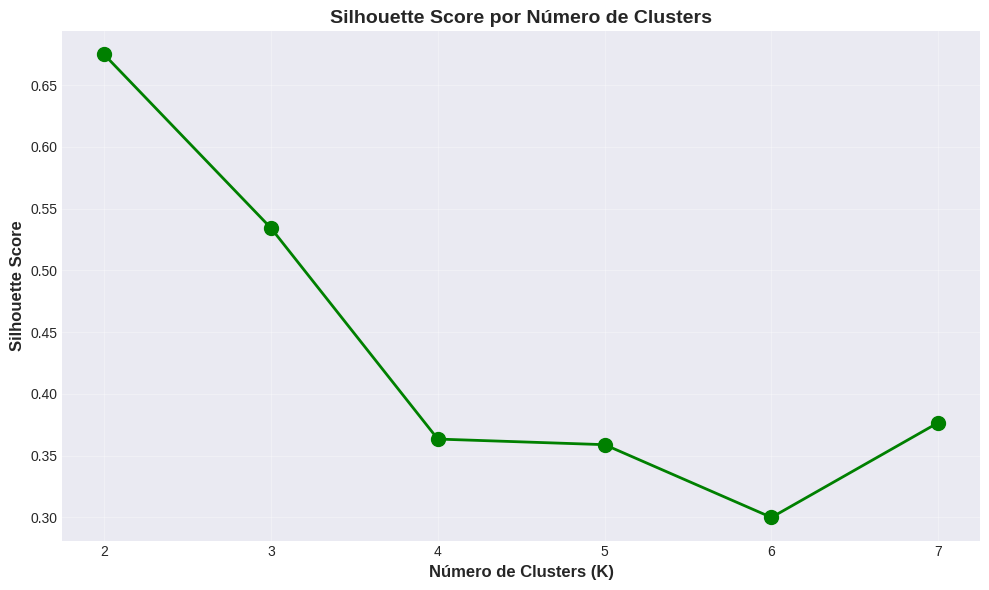

In [22]:
print("\n🎯 Silhouette Score para diferentes valores de K:")

silhouette_scores = []

for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)
    print(f"  K={k}: Silhouette Score = {score:.3f}")

plt.figure(figsize=(10, 6))
plt.plot(range(2, 8), silhouette_scores, 'go-', linewidth=2, markersize=10)
plt.xlabel('Número de Clusters (K)', fontsize=12, fontweight='bold')
plt.ylabel('Silhouette Score', fontsize=12, fontweight='bold')
plt.title('Silhouette Score por Número de Clusters', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(range(2, 8))
plt.tight_layout()
plt.show()

### **Clustering com K-MEANS (K = 3)**

Agrupamento das 17 DRS em 3 clusters com base em CAPS/100k e internações/100k

**Resultado esperado:**
- **Cluster 0:** DRS com características similares tipo A
- **Cluster 1:** DRS com características similares tipo B
- **Cluster 2:** DRS com características similares tipo C

A interpretação dos clusters será feita na próxima seção.

In [23]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
df_drs['cluster'] = kmeans.fit_predict(X_scaled)


### **Estatísticas descritivas por cluster**

**Objetivo:** Caracterizar cada cluster identificando:
- Quais DRS pertencem a cada grupo
- Médias de CAPS/100k e internações/100k
- População total e volumes absolutos

In [26]:
print("ESTATÍSTICAS DESCRITIVAS POR CLUSTER")

for c in sorted(df_drs['cluster'].unique()):
    cluster_data = df_drs[df_drs['cluster'] == c]
    print(f"\n{'-'*70}")
    print(f"CLUSTER {c} - {len(cluster_data)} DRS")
    print(f"{'-'*70}")
    print(f"\nDRS incluídas:")
    for drs in cluster_data['drs'].tolist():
        print(f"   • {drs}")

    print(f"\nCAPS por 100k habitantes:")
    print(f"   Média:    {cluster_data['caps_100k'].mean():.2f}")
    print(f"   Mediana:  {cluster_data['caps_100k'].median():.2f}")
    print(f"   Mín-Máx:  {cluster_data['caps_100k'].min():.2f} - {cluster_data['caps_100k'].max():.2f}")

    print(f"\nInternações por 100k habitantes:")
    print(f"   Média:    {cluster_data['internacoes_100k'].mean():.2f}")
    print(f"   Mediana:  {cluster_data['internacoes_100k'].median():.2f}")
    print(f"   Mín-Máx:  {cluster_data['internacoes_100k'].min():.2f} - {cluster_data['internacoes_100k'].max():.2f}")

    print(f"\nPopulação total: {cluster_data['population'].sum():,.0f} habitantes")
    print(f"Total de CAPS: {cluster_data['quantidade_caps'].sum()}")
    print(f"Total de internações: {cluster_data['quantidade_internacoes'].sum():,.0f}")

ESTATÍSTICAS DESCRITIVAS POR CLUSTER

----------------------------------------------------------------------
CLUSTER 0 - 4 DRS
----------------------------------------------------------------------

DRS incluídas:
   • DRS Franca
   • DRS Marília
   • DRS Presidente Prudente
   • DRS Registro

CAPS por 100k habitantes:
   Média:    2.30
   Mediana:  2.31
   Mín-Máx:  2.08 - 2.52

Internações por 100k habitantes:
   Média:    1146.62
   Mediana:  1309.13
   Mín-Máx:  118.05 - 1850.17

População total: 2,812,109 habitantes
Total de CAPS: 63
Total de internações: 39,671

----------------------------------------------------------------------
CLUSTER 1 - 12 DRS
----------------------------------------------------------------------

DRS incluídas:
   • DRS Araraquara
   • DRS Araçatuba
   • DRS Baixada Santista
   • DRS Barretos
   • DRS Bauru
   • DRS Campinas
   • DRS Grande São Paulo
   • DRS Piracicaba
   • DRS Ribeirão Preto
   • DRS Sorocaba
   • DRS São José do Rio Preto
   • DRS Taub

### **Visualização dos Clusters (Scatter Plot)**

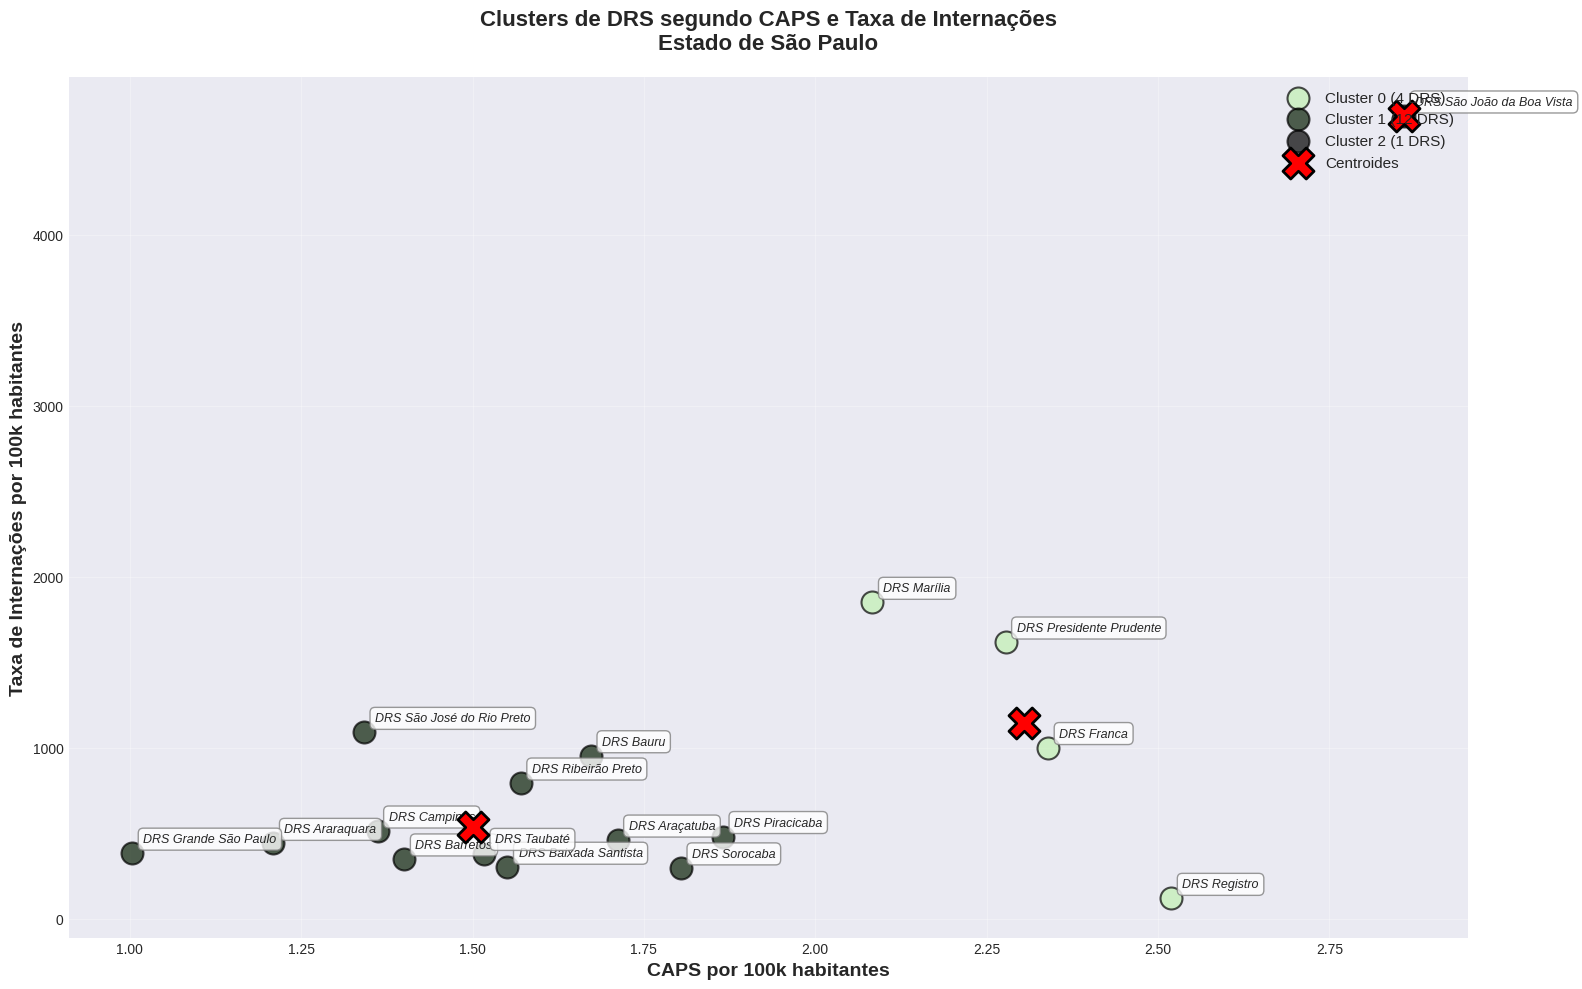

In [28]:
plt.figure(figsize=(16, 10))

# Paleta de cores
colors = ['#c2f1b3', '#092006', '#000000']

# Plot dos clusters
for c in sorted(df_drs['cluster'].unique()):
    subset = df_drs[df_drs['cluster'] == c]
    plt.scatter(subset['caps_100k'], subset['internacoes_100k'],
                label=f'Cluster {c} ({len(subset)} DRS)',
                s=250, alpha=0.7, color=colors[c],
                edgecolors='black', linewidth=1.5)

# Centroides
centroides = scaler.inverse_transform(kmeans.cluster_centers_)
plt.scatter(centroides[:, 0], centroides[:, 1],
            marker='X', s=500, c='red', edgecolors='black',
            linewidth=2, label='Centroides', zorder=5)

# Anotações
for i, row in df_drs.iterrows():
    plt.annotate(row['drs'],
                 (row['caps_100k'], row['internacoes_100k']),
                 xytext=(8, 8), textcoords='offset points',
                 fontsize=9, ha='left', style='italic',
                 bbox=dict(boxstyle='round,pad=0.4', facecolor='white',
                          alpha=0.8, edgecolor='gray'))

plt.xlabel('CAPS por 100k habitantes', fontsize=14, fontweight='bold')
plt.ylabel('Taxa de Internações por 100k habitantes', fontsize=14, fontweight='bold')
plt.title('Clusters de DRS segundo CAPS e Taxa de Internações\nEstado de São Paulo',
          fontsize=16, fontweight='bold', pad=20)
plt.legend(fontsize=11, loc='upper right', framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### **Gráfico de Silhouette por cluster**

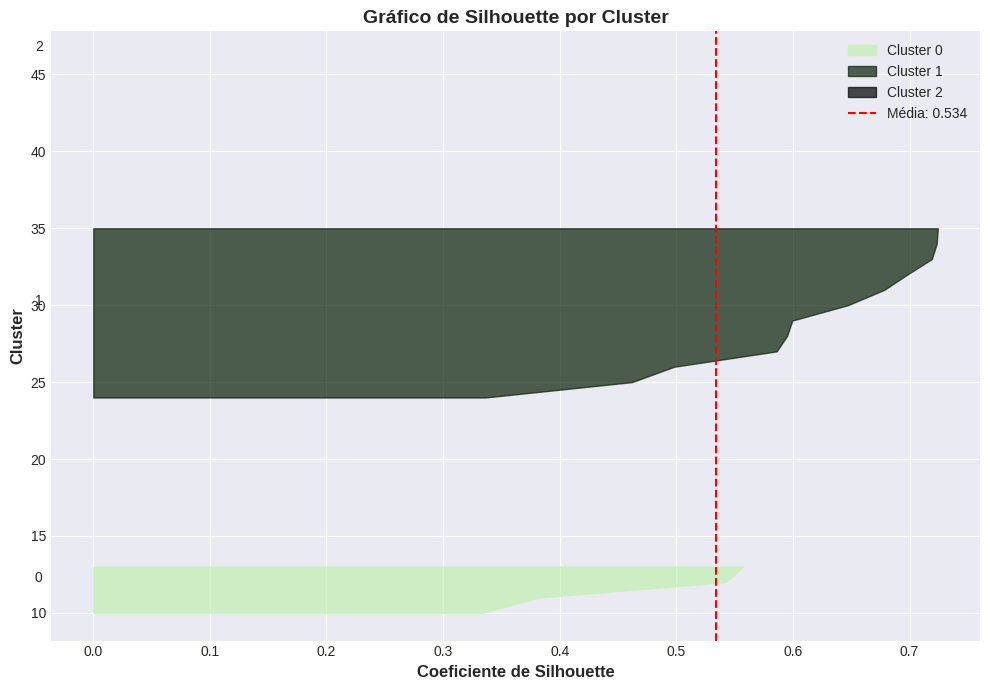

In [29]:
silhouette_vals = silhouette_samples(X_scaled, df_drs['cluster'])

fig, ax = plt.subplots(figsize=(10, 7))

y_lower = 10
for i in sorted(df_drs['cluster'].unique()):
    cluster_silhouette_vals = silhouette_vals[df_drs['cluster'] == i]
    cluster_silhouette_vals.sort()

    size_cluster_i = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i

    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals,
                     alpha=0.7, color=colors[i], label=f'Cluster {i}')
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

ax.set_xlabel('Coeficiente de Silhouette', fontsize=12, fontweight='bold')
ax.set_ylabel('Cluster', fontsize=12, fontweight='bold')
ax.set_title('Gráfico de Silhouette por Cluster', fontsize=14, fontweight='bold')
ax.axvline(x=silhouette_score(X_scaled, df_drs['cluster']),
           color="red", linestyle="--", label=f'Média: {silhouette_score(X_scaled, df_drs["cluster"]):.3f}')
ax.legend(loc='best')
plt.tight_layout()
plt.show()

### **Boxplot por cluster**

Aqui o objetivo é comparar distribuições de CAPS/100k e internações/100k entre clusters para identificar dispersão interna e outliers dentro de cada cluster.

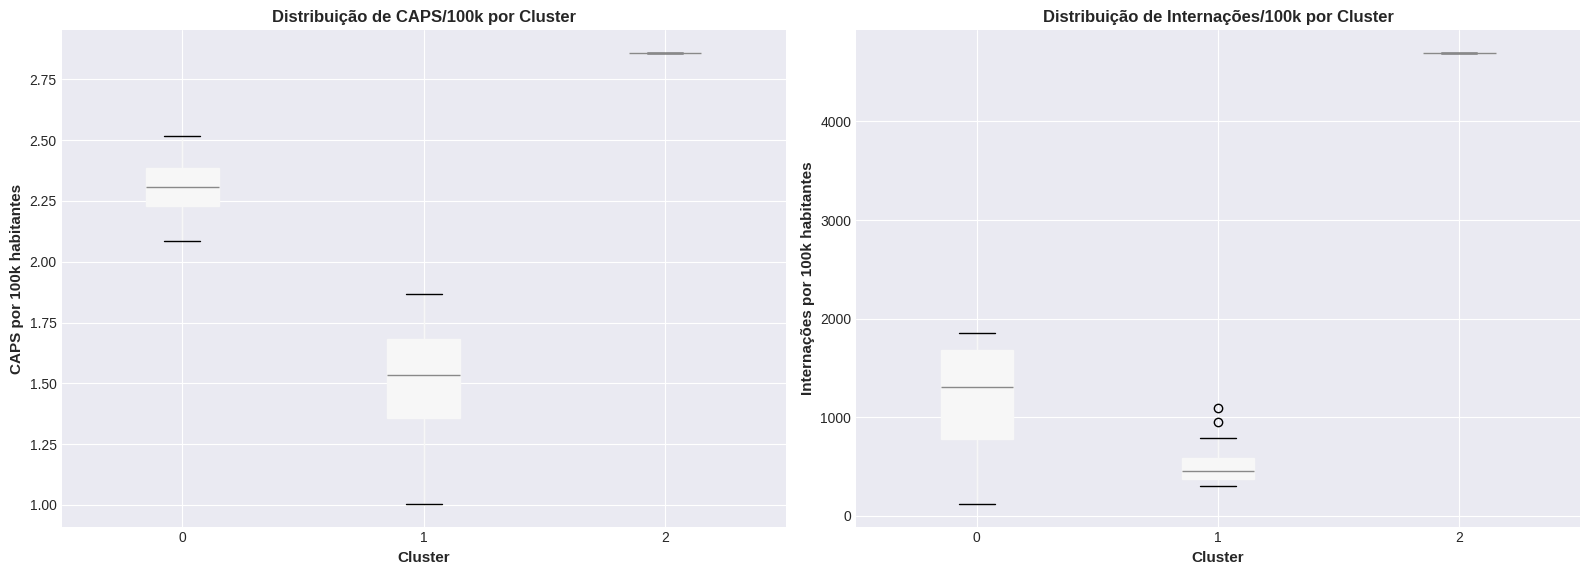

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Boxplot CAPS
df_drs.boxplot(column='caps_100k', by='cluster', ax=axes[0], patch_artist=True)
axes[0].set_title('Distribuição de CAPS/100k por Cluster', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Cluster', fontsize=11, fontweight='bold')
axes[0].set_ylabel('CAPS por 100k habitantes', fontsize=11, fontweight='bold')

# Boxplot Internações
df_drs.boxplot(column='internacoes_100k', by='cluster', ax=axes[1], patch_artist=True)
axes[1].set_title('Distribuição de Internações/100k por Cluster', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Cluster', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Internações por 100k habitantes', fontsize=11, fontweight='bold')

plt.suptitle('')
plt.tight_layout()
plt.show()

## **Análise Final**

In [32]:
print("RESUMO DA ANÁLISE")
print(f"\nTotal de DRS analisadas: {len(df_drs)}")
print(f"Número de clusters identificados: {df_drs['cluster'].nunique()}")
print(f"Inércia do modelo: {kmeans.inertia_:.2f}")

RESUMO DA ANÁLISE

Total de DRS analisadas: 17
Número de clusters identificados: 3
Inércia do modelo: 5.68


# **Análise de Variáveis Sociodemográficas**



## **Agregação de Dados Sociodemográficos por DRS**

In [33]:
print(df_sih.columns.tolist())

['Unnamed: 0.1', 'Unnamed: 0', 'UF_ZI', 'ANO_CMPT', 'MES_CMPT', 'NASC', 'IDADE', 'SEXO', 'RACA_COR', 'ESPEC', 'IDENT', 'MUNIC_RES', 'DIAG_PRINC', 'DIAG_SECUN', 'CAR_INT', 'COBRANCA', 'MUNIC_MOV', 'CID_ASSO', 'CID_MORTE', 'COMPLEX', 'DT_INTER', 'DT_SAIDA', 'QT_DIARIAS', 'DIAS_PERM', 'MORTE', 'ANO', 'cod_mun6']


In [34]:
# Merge para adicionar DRS
df_sih_drs = df_sih.merge(
    df_regioes[['cod_mun6', 'drs']],
    on='cod_mun6',
    how='left'
)

print(f"✅ df_sih_drs criado: {len(df_sih_drs)} internações")

✅ df_sih_drs criado: 265752 internações


### **Estatística de Idade**

**Objetivo:** Calcular estatísticas de idade (média, mediana, etc.) dos pacientes internados em cada DRS

In [35]:
perfil_idade = df_sih_drs.groupby('drs')['IDADE'].agg([
    ('idade_media', 'mean'),
    ('idade_mediana', 'median'),
    ('idade_std', 'std'),
    ('idade_min', 'min'),
    ('idade_max', 'max')
]).reset_index()

print(f"✅ perfil_idade: {len(perfil_idade)} DRS")
print("Colunas:", perfil_idade.columns.tolist())

✅ perfil_idade: 17 DRS
Colunas: ['drs', 'idade_media', 'idade_mediana', 'idade_std', 'idade_min', 'idade_max']


### **Agregação de Sexo**

**Objetivo:** Calcular proporção de homens e mulheres internados em cada DRS

In [36]:
sexo_dados = []

for drs_nome in df_sih_drs['drs'].unique():
    subset = df_sih_drs[df_sih_drs['drs'] == drs_nome]['SEXO']

    total = len(subset)
    masc = (subset == 'Masculino').sum()
    fem = (subset == 'Feminino').sum()

    sexo_dados.append({
        'drs': drs_nome,
        'prop_masculino': (masc / total * 100) if total > 0 else 0,
        'prop_feminino': (fem / total * 100) if total > 0 else 0,
        'total_masculino': masc,
        'total_feminino': fem,
        'total_casos': total
    })

perfil_sexo = pd.DataFrame(sexo_dados)

print(f"✅ perfil_sexo: {len(perfil_sexo)} DRS")
print("Colunas:", perfil_sexo.columns.tolist())

✅ perfil_sexo: 17 DRS
Colunas: ['drs', 'prop_masculino', 'prop_feminino', 'total_masculino', 'total_feminino', 'total_casos']


### **Agregação de Raça/Cor**

**Objetivo:** Calcular proporção de cada raça/cor autodeclarada nas internações
por DRS

In [37]:
# Criar dicionário para cada DRS
raca_dados = []

for drs_nome in df_sih_drs['drs'].unique():
  subset = df_sih_drs[df_sih_drs['drs'] == drs_nome]['RACA_COR']
  total = len(subset)

  raca_dados.append({
    'drs': drs_nome,
    'prop_branca': ((subset == 'Branca').sum() / total * 100) if total > 0 else 0,
    'prop_preta': ((subset == 'Preta').sum() / total * 100) if total > 0 else 0,
    'prop_parda': ((subset == 'Parda').sum() / total * 100) if total > 0 else 0,
    'prop_amarela': ((subset == 'Amarela').sum() / total * 100) if total > 0 else 0,
    'prop_indigena': ((subset == 'Indígena').sum() / total * 100) if total > 0 else 0,
    'prop_ignorado': ((subset == 'Ignorado').sum() / total * 100) if total > 0 else 0
  })

perfil_raca = pd.DataFrame(raca_dados)

print(f"✅ perfil_raca: {len(perfil_raca)} DRS")
print("Colunas:", perfil_raca.columns.tolist())


✅ perfil_raca: 17 DRS
Colunas: ['drs', 'prop_branca', 'prop_preta', 'prop_parda', 'prop_amarela', 'prop_indigena', 'prop_ignorado']


### **Merge de todos os perfis sociodemográficos**

**Objetivo:** Criar dataframe final (df_analise) que combina:
- Dados do clustering (df_drs): internações/100k, CAPS/100k, cluster
- Perfil de idade
- Perfil de sexo
- Perfil de raça/cor

In [38]:
df_analise = df_drs.copy()

# Merge 1: IDADE
df_analise = df_analise.merge(perfil_idade, on='drs', how='left', validate='1:1')
print(f"   Após merge idade: {len(df_analise)} DRS, {len(df_analise.columns)} colunas")

# Merge 2: SEXO
df_analise = df_analise.merge(perfil_sexo, on='drs', how='left', validate='1:1')
print(f"   Após merge sexo: {len(df_analise)} DRS, {len(df_analise.columns)} colunas")

# Merge 3: RAÇA
df_analise = df_analise.merge(perfil_raca, on='drs', how='left', validate='1:1')
print(f"   Após merge raça: {len(df_analise)} DRS, {len(df_analise.columns)} colunas")


   Após merge idade: 17 DRS, 14 colunas
   Após merge sexo: 17 DRS, 19 colunas
   Após merge raça: 17 DRS, 25 colunas


In [39]:
df_analise.head()

,drs,quantidade_internacoes,population,quantidade_caps,internacoes_100k,caps_100k,z_caps,z_internacoes,cluster,idade_media,...,prop_feminino,total_masculino,total_feminino,total_casos,prop_branca,prop_preta,prop_parda,prop_amarela,prop_indigena,prop_ignorado
0,DRS Araraquara,4364,992306,12,439.783696,1.209304,1.156367,0.461075,1,39.563245,...,48.006416,2269,2095,4364,59.303391,9.990834,29.422548,0.664528,0.0,0.595784
1,DRS Araçatuba,3487,759557,13,459.083387,1.711524,0.120126,0.442715,1,41.348724,...,43.188988,1981,1506,3487,73.587611,1.462575,10.553484,0.200746,0.0,14.195584
2,DRS Baixada Santista,5419,1805531,28,300.133313,1.550790,0.451772,0.593924,1,36.763056,...,50.046134,2707,2712,5419,28.732238,6.034324,55.545304,0.239897,0.0,9.429784
3,DRS Barretos,1494,428479,6,348.675198,1.400302,0.762278,0.547746,1,39.105087,...,52.409639,711,783,1494,39.223561,9.236948,47.791165,3.748327,0.0,0.000000
4,DRS Bauru,16513,1733827,29,952.401826,1.672601,0.200438,0.026577,1,40.877067,...,39.629383,9969,6544,16513,62.266093,13.141162,23.278629,1.223279,0.0,0.072670


## **Análise Descritiva por Cluster (Com Variáveis Sociodemográficas)**

**Objetivo:** Verificar se os clusters identificados anteriormente (baseados em CAPS e internações) também diferem em termos demográficos para entender se fatores como idade, sexo e raça estão associados aos padrões de internação.

In [40]:
print("\n\nPERFIL DEMOGRÁFICO POR CLUSTER")

for c in sorted(df_analise['cluster'].unique()):
    cluster_data = df_analise[df_analise['cluster'] == c]

    print(f"\n{'-'*70}")
    print(f"CLUSTER {c} - {len(cluster_data)} DRS")
    print(f"{'-'*70}")

    print(f"\nDRS incluídas:")
    for drs in cluster_data['drs'].tolist():
        print(f"   • {drs}")

    print(f"\nPERFIL DEMOGRÁFICO:")
    print(f"   Idade média: {cluster_data['idade_media'].mean():.1f} anos")
    print(f"   Idade mediana: {cluster_data['idade_mediana'].mean():.1f} anos")
    print(f"   Idade mín-máx: {cluster_data['idade_min'].mean():.1f} - {cluster_data['idade_max'].mean():.1f} anos")
    print(f"   Proporção masculino: {cluster_data['prop_masculino'].mean():.1f}%")
    print(f"   Proporção feminino: {cluster_data['prop_feminino'].mean():.1f}%")

    if perfil_raca is not None:
        print(f"\nDISTRIBUIÇÃO RACIAL:")
        print(f"   Branca: {cluster_data['prop_branca'].mean():.1f}%")
        print(f"   Preta: {cluster_data['prop_preta'].mean():.1f}%")
        print(f"   Parda: {cluster_data['prop_parda'].mean():.1f}%")
        print(f"   Amarela: {cluster_data['prop_amarela'].mean():.1f}%")
        print(f"   Indígena: {cluster_data['prop_indigena'].mean():.1f}%")

    print(f"\nINDICADORES DE SAÚDE MENTAL:")
    print(f"   CAPS/100k: {cluster_data['caps_100k'].mean():.2f}")
    print(f"   Internações/100k: {cluster_data['internacoes_100k'].mean():.2f}")
    print(f"   Total CAPS: {cluster_data['quantidade_caps'].sum()}")
    print(f"   Total internações: {cluster_data['quantidade_internacoes'].sum():,.0f}")
    print(f"   População: {cluster_data['population'].sum():,.0f} hab")



PERFIL DEMOGRÁFICO POR CLUSTER

----------------------------------------------------------------------
CLUSTER 0 - 4 DRS
----------------------------------------------------------------------

DRS incluídas:
   • DRS Franca
   • DRS Marília
   • DRS Presidente Prudente
   • DRS Registro

PERFIL DEMOGRÁFICO:
   Idade média: 38.7 anos
   Idade mediana: 37.5 anos
   Idade mín-máx: 2.5 - 92.8 anos
   Proporção masculino: 60.7%
   Proporção feminino: 39.3%

DISTRIBUIÇÃO RACIAL:
   Branca: 55.3%
   Preta: 7.1%
   Parda: 36.9%
   Amarela: 0.4%
   Indígena: 0.0%

INDICADORES DE SAÚDE MENTAL:
   CAPS/100k: 2.30
   Internações/100k: 1146.62
   Total CAPS: 63
   Total internações: 39,671
   População: 2,812,109 hab

----------------------------------------------------------------------
CLUSTER 1 - 12 DRS
----------------------------------------------------------------------

DRS incluídas:
   • DRS Araraquara
   • DRS Araçatuba
   • DRS Baixada Santista
   • DRS Barretos
   • DRS Bauru
   • DRS

### **Matriz de Correlação Expandida**

**Objetivo:** Identificar quais variáveis sociodemográficas têm relação com a taxa de internações

**Interpretação:**
- **Correlação forte (|r| > 0.5):** variável tem relação importante
- **Correlação moderada (0.3 < |r| < 0.5):** relação moderada
- **Correlação fraca (|r| < 0.3):** pouca ou nenhuma relação



📈 ANÁLISE DE CORRELAÇÕES


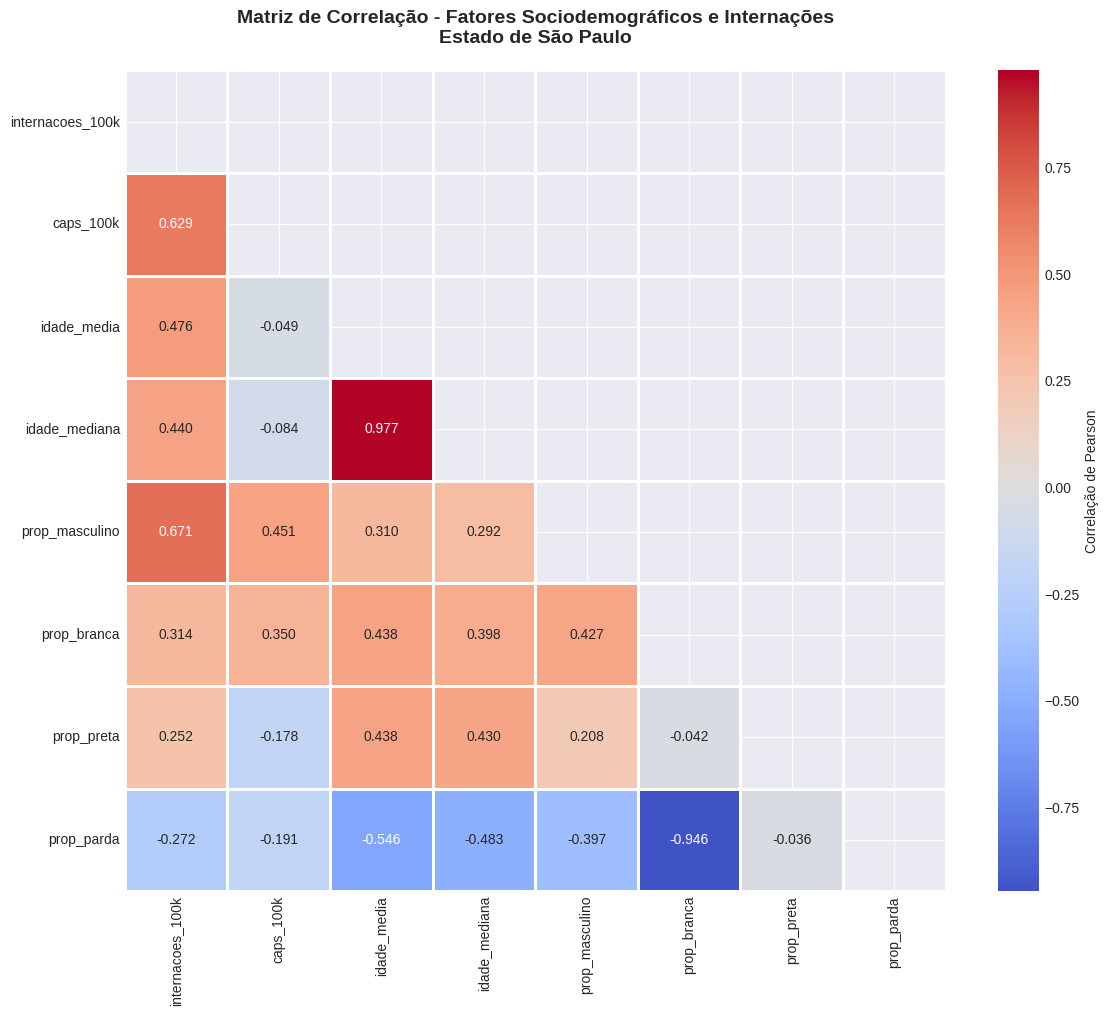


🔍 CORRELAÇÕES COM TAXA DE INTERNAÇÕES (ordenadas):
--------------------------------------------------------------------------------
📈 🔴 prop_masculino      : +0.671 (FORTE)
📈 🔴 caps_100k           : +0.629 (FORTE)
📈 🟡 idade_media         : +0.476 (MODERADA)
📈 🟡 idade_mediana       : +0.440 (MODERADA)
📈 🟡 prop_branca         : +0.314 (MODERADA)
📉 🟢 prop_parda          : -0.272 (FRACA)
📈 🟢 prop_preta          : +0.252 (FRACA)


In [41]:
print("\n\n📈 ANÁLISE DE CORRELAÇÕES")
print("="*80)

# Selecionar variáveis numéricas
vars_correlacao = ['internacoes_100k', 'caps_100k', 'idade_media',
                   'idade_mediana', 'prop_masculino']

if perfil_raca is not None:
    vars_correlacao.extend(['prop_branca', 'prop_preta', 'prop_parda'])

# Matriz de correlação
df_corr = df_analise[vars_correlacao].corr()

# Visualizar
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(df_corr, dtype=bool))
sns.heatmap(df_corr, mask=mask, annot=True, fmt='.3f', cmap='coolwarm',
            center=0, square=True, linewidths=1,
            cbar_kws={'label': 'Correlação de Pearson'})
plt.title('Matriz de Correlação - Fatores Sociodemográficos e Internações\nEstado de São Paulo',
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Identificar correlações mais fortes
print("\n🔍 CORRELAÇÕES COM TAXA DE INTERNAÇÕES (ordenadas):")
print("-"*80)
corr_internacoes = df_corr['internacoes_100k'].drop('internacoes_100k').sort_values(
    ascending=False, key=abs
)

for var, corr in corr_internacoes.items():
    emoji = "📈" if corr > 0 else "📉"
    if abs(corr) > 0.5:
        strength = "FORTE"
        color = "🔴"
    elif abs(corr) > 0.3:
        strength = "MODERADA"
        color = "🟡"
    else:
        strength = "FRACA"
        color = "🟢"

    print(f"{emoji} {color} {var:20s}: {corr:+.3f} ({strength})")

## **Regressão Linear Múltipla**

**Objetivo:** Construir modelo preditivo para entender quais fatores explicam a variação nas taxas de internação

**Método: Regressão linear com múltiplas variáveis independentes**

**Métricas**:
- R²: proporção da variância explicada (0 a 1)
- Coeficientes: impacto de cada variável (mantendo outras constantes)

**Interpretação dos coeficientes:**
- Positivo: aumento na variável aumenta internações
- Negativo: aumento na variável diminui internações
- Magnitude: tamanho do efeito



REGRESSÃO LINEAR - IDENTIFICANDO FATORES PREDITORES

R² do modelo: 0.7714
   Interpretação: O modelo explica 77.1% da variação nas internações
   ✅ EXCELENTE poder explicativo!

COEFICIENTES (impacto de cada variável):
--------------------------------------------------------------------------------

Variável              Coeficiente Interpretação                           
--------------------------------------------------------------------------------
⬆️ caps_100k              +1228.53    Cada +1 aumenta 1228.5 internações/100k
⬆️ idade_media             +168.95    Cada +1 aumenta 169.0 internações/100k
⬆️ prop_masculino           +62.49    Cada +1 aumenta 62.5 internações/100k
⬇️ prop_branca              -12.35    Cada +1 diminui 12.4 internações/100k
⬆️ prop_parda               +10.75    Cada +1 aumenta 10.8 internações/100k

Intercepto: -11314.29


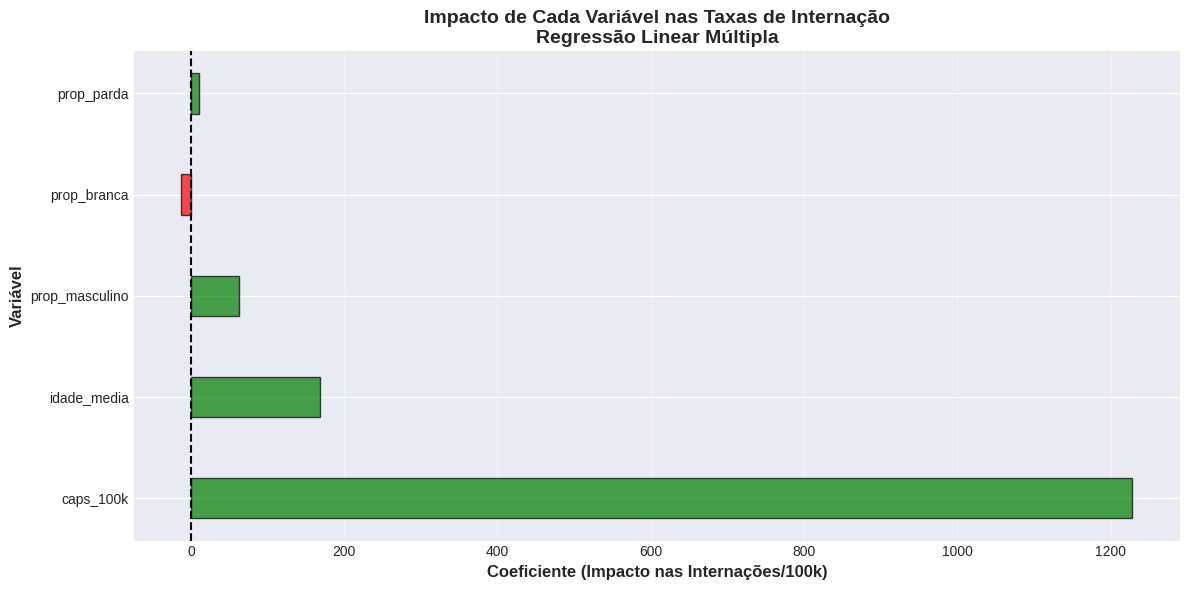

In [43]:
print("\n\nREGRESSÃO LINEAR - IDENTIFICANDO FATORES PREDITORES")

from sklearn.linear_model import LinearRegression

variaveis_x = ['caps_100k', 'idade_media', 'prop_masculino']
if perfil_raca is not None:
    variaveis_x.extend(['prop_branca', 'prop_parda'])

# Preparação dados
X = df_analise[variaveis_x].fillna(df_analise[variaveis_x].mean())
y = df_analise['internacoes_100k']

# Ajuste do modelo
modelo = LinearRegression()
modelo.fit(X, y)

# Métricas
r2 = modelo.score(X, y)
print(f"\nR² do modelo: {r2:.4f}")
print(f"   Interpretação: O modelo explica {r2*100:.1f}% da variação nas internações")

if r2 > 0.7:
    print("   ✅ EXCELENTE poder explicativo!")
elif r2 > 0.5:
    print("   ✅ BOM poder explicativo")
elif r2 > 0.3:
    print("   ⚠️  MODERADO poder explicativo")
else:
    print("   ⚠️  BAIXO poder explicativo")

# Coeficientes
print(f"\nCOEFICIENTES (impacto de cada variável):")
print("-"*80)

coef_df = pd.DataFrame({
    'Variável': variaveis_x,
    'Coeficiente': modelo.coef_,
    'Abs': np.abs(modelo.coef_)
}).sort_values('Abs', ascending=False)

print(f"\n{'Variável':<20s} {'Coeficiente':>12s} {'Interpretação':<40s}")
print("-"*80)

for _, row in coef_df.iterrows():
    emoji = "⬆️ " if row['Coeficiente'] > 0 else "⬇️ "
    interpretacao = "aumenta" if row['Coeficiente'] > 0 else "diminui"
    print(f"{emoji}{row['Variável']:<18s} {row['Coeficiente']:>+12.2f}    "
          f"Cada +1 {interpretacao} {abs(row['Coeficiente']):.1f} internações/100k")

print(f"\nIntercepto: {modelo.intercept_:.2f}")

# Visualizar importância
plt.figure(figsize=(12, 6))
colors = ['green' if c > 0 else 'red' for c in coef_df['Coeficiente']]
plt.barh(coef_df['Variável'], coef_df['Coeficiente'], color=colors, alpha=0.7, edgecolor='black', height=0.4)
plt.xlabel('Coeficiente (Impacto nas Internações/100k)', fontweight='bold', fontsize=12)
plt.ylabel('Variável', fontweight='bold', fontsize=12)
plt.title('Impacto de Cada Variável nas Taxas de Internação\nRegressão Linear Múltipla',
          fontweight='bold', fontsize=14)
plt.axvline(x=0, color='black', linestyle='--', linewidth=1.5)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

### **Random Forest - Importância das Variáveis**

**Objetivo:** Complementar análise de regressão com método não-linear

**Vantagens do Random Forest:**
- Captura relações não-lineares
- Menos sensível a outliers
- Fornece ranking de importância

**Interpretação:** Variáveis com maior importância têm mais influência na predição das internações



RANDOM FOREST - RANKING DE IMPORTÂNCIA

R² do Random Forest: 0.8919 (89.2%)

RANKING DE IMPORTÂNCIA:
--------------------------------------------------------------------------------
idade_media          ██████████████████  30.8%
prop_masculino       █████████████████  29.6%
caps_100k            █████████████████  28.7%
prop_parda           ████   8.1%
prop_branca          █   2.8%

Variável mais importante: idade_media


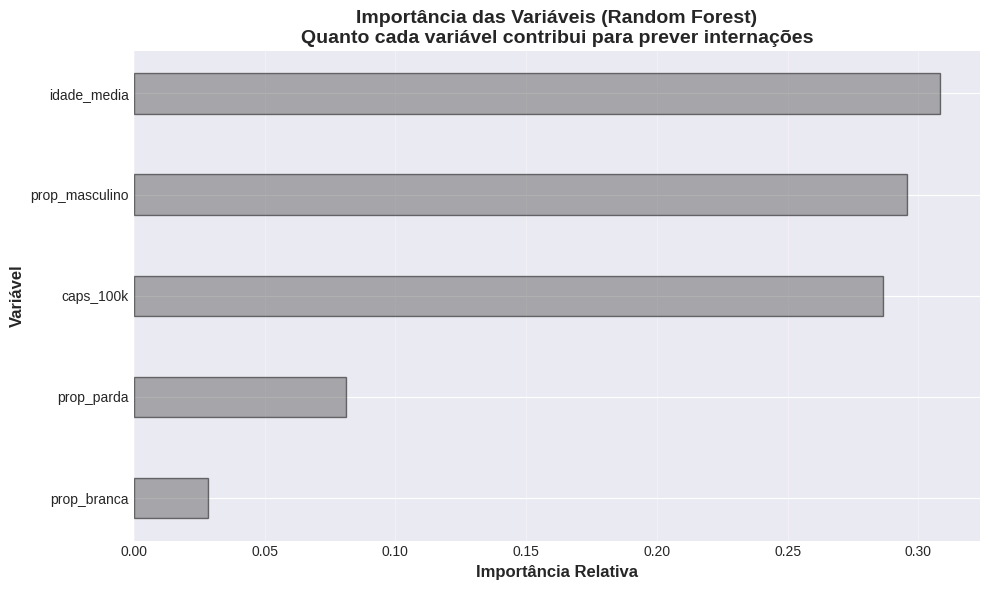

In [44]:
print("\n\nRANDOM FOREST - RANKING DE IMPORTÂNCIA")

from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5)
rf_model.fit(X, y)

# Score
rf_score = rf_model.score(X, y)
print(f"\nR² do Random Forest: {rf_score:.4f} ({rf_score*100:.1f}%)")

# Importância
importances = pd.DataFrame({
    'Variável': variaveis_x,
    'Importância': rf_model.feature_importances_
}).sort_values('Importância', ascending=False)

print("\nRANKING DE IMPORTÂNCIA:")
print("-"*80)

for i, row in importances.iterrows():
    bar = "█" * int(row['Importância'] * 60)
    print(f"{row['Variável']:20s} {bar} {row['Importância']*100:5.1f}%")

print(f"\nVariável mais importante: {importances.iloc[0]['Variável']}")

# Visualizar
plt.figure(figsize=(10, 6))
plt.barh(importances['Variável'], importances['Importância'],
         color='#636363', alpha=0.5, edgecolor='black', height=0.4)
plt.gca().invert_yaxis()
plt.xlabel('Importância Relativa', fontweight='bold', fontsize=12)
plt.ylabel('Variável', fontweight='bold', fontsize=12)
plt.title('Importância das Variáveis (Random Forest)\nQuanto cada variável contribui para prever internações',
          fontweight='bold', fontsize=14)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

### **Gráfico comparativos por cluster**




📊 VISUALIZAÇÕES COMPARATIVAS POR CLUSTER


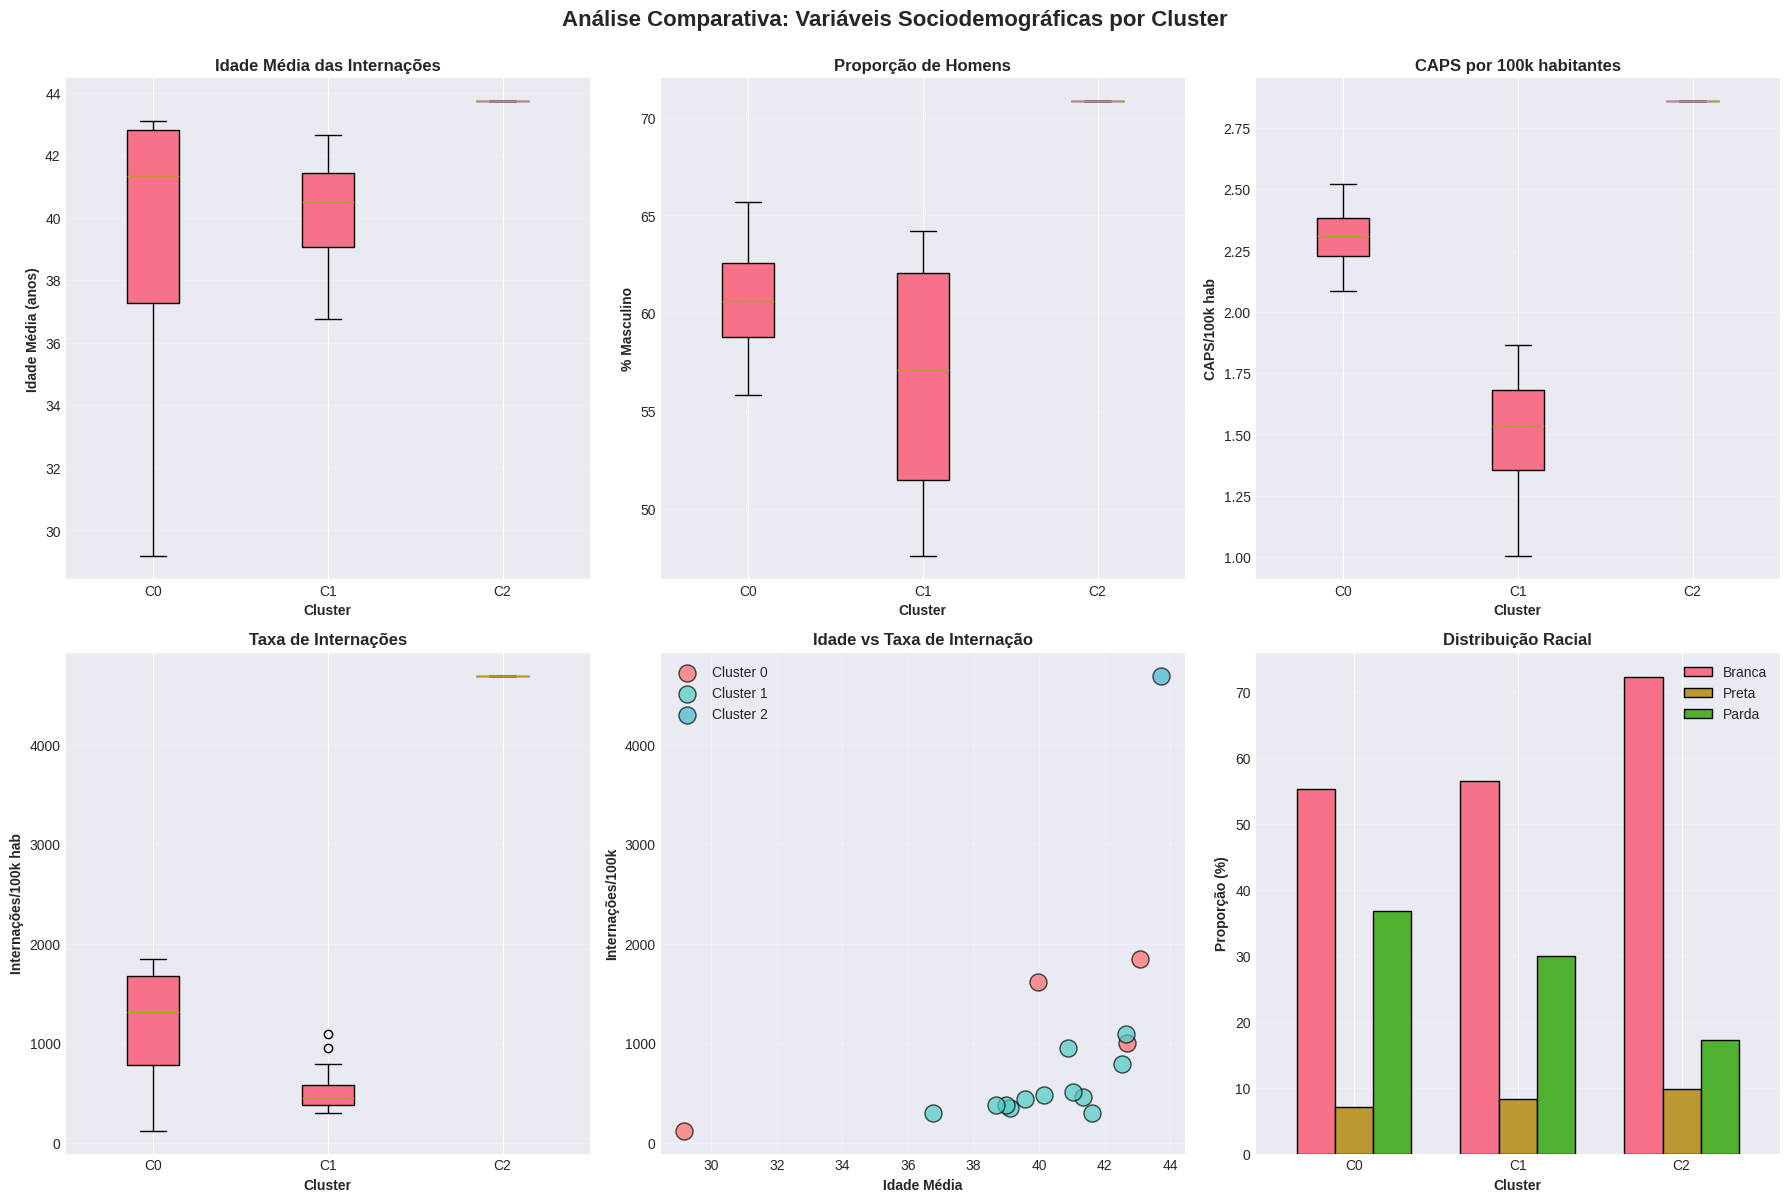

In [45]:
print("\n\n📊 VISUALIZAÇÕES COMPARATIVAS POR CLUSTER")
print("="*80)

# Número de gráficos depende de ter ou não dados raciais
n_plots = 6 if perfil_raca is not None else 5
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

# 1. Idade Média
bp1 = axes[0].boxplot([df_analise[df_analise['cluster'] == c]['idade_media'].dropna()
                        for c in sorted(df_analise['cluster'].unique())],
                       labels=[f'C{c}' for c in sorted(df_analise['cluster'].unique())],
                       patch_artist=True)
axes[0].set_ylabel('Idade Média (anos)', fontweight='bold')
axes[0].set_xlabel('Cluster', fontweight='bold')
axes[0].set_title('Idade Média das Internações', fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# 2. Proporção Masculino
bp2 = axes[1].boxplot([df_analise[df_analise['cluster'] == c]['prop_masculino'].dropna()
                        for c in sorted(df_analise['cluster'].unique())],
                       labels=[f'C{c}' for c in sorted(df_analise['cluster'].unique())],
                       patch_artist=True)
axes[1].set_ylabel('% Masculino', fontweight='bold')
axes[1].set_xlabel('Cluster', fontweight='bold')
axes[1].set_title('Proporção de Homens', fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# 3. CAPS/100k
bp3 = axes[2].boxplot([df_analise[df_analise['cluster'] == c]['caps_100k'].dropna()
                        for c in sorted(df_analise['cluster'].unique())],
                       labels=[f'C{c}' for c in sorted(df_analise['cluster'].unique())],
                       patch_artist=True)
axes[2].set_ylabel('CAPS/100k hab', fontweight='bold')
axes[2].set_xlabel('Cluster', fontweight='bold')
axes[2].set_title('CAPS por 100k habitantes', fontweight='bold')
axes[2].grid(axis='y', alpha=0.3)

# 4. Internações/100k
bp4 = axes[3].boxplot([df_analise[df_analise['cluster'] == c]['internacoes_100k'].dropna()
                        for c in sorted(df_analise['cluster'].unique())],
                       labels=[f'C{c}' for c in sorted(df_analise['cluster'].unique())],
                       patch_artist=True)
axes[3].set_ylabel('Internações/100k hab', fontweight='bold')
axes[3].set_xlabel('Cluster', fontweight='bold')
axes[3].set_title('Taxa de Internações', fontweight='bold')
axes[3].grid(axis='y', alpha=0.3)

# 5. Dispersão: Idade vs Internações
colors_scatter = ['#FF6B6B', '#4ECDC4', '#45B7D1']
for c in sorted(df_analise['cluster'].unique()):
    subset = df_analise[df_analise['cluster'] == c]
    axes[4].scatter(subset['idade_media'], subset['internacoes_100k'],
                   label=f'Cluster {c}', s=150, alpha=0.7,
                   color=colors_scatter[c], edgecolors='black', linewidth=1)
axes[4].set_xlabel('Idade Média', fontweight='bold')
axes[4].set_ylabel('Internações/100k', fontweight='bold')
axes[4].set_title('Idade vs Taxa de Internação', fontweight='bold')
axes[4].legend()
axes[4].grid(True, alpha=0.3)

# 6. Raça/Cor ou Sexo
if perfil_raca is not None:
    cluster_raca = df_analise.groupby('cluster')[['prop_branca', 'prop_preta', 'prop_parda']].mean()
    cluster_raca.plot(kind='bar', ax=axes[5], width=0.7, edgecolor='black')
    axes[5].set_xlabel('Cluster', fontweight='bold')
    axes[5].set_ylabel('Proporção (%)', fontweight='bold')
    axes[5].set_title('Distribuição Racial', fontweight='bold')
    axes[5].legend(['Branca', 'Preta', 'Parda'])
    axes[5].set_xticklabels([f'C{c}' for c in sorted(df_analise['cluster'].unique())], rotation=0)
    axes[5].grid(axis='y', alpha=0.3)
else:
    # Gráfico alternativo: distribuição de sexo
    cluster_sexo = df_analise.groupby('cluster')[['prop_masculino', 'prop_feminino']].mean()
    cluster_sexo.plot(kind='bar', ax=axes[5], width=0.7, edgecolor='black')
    axes[5].set_xlabel('Cluster', fontweight='bold')
    axes[5].set_ylabel('Proporção (%)', fontweight='bold')
    axes[5].set_title('Distribuição por Sexo', fontweight='bold')
    axes[5].legend(['Masculino', 'Feminino'])
    axes[5].set_xticklabels([f'C{c}' for c in sorted(df_analise['cluster'].unique())], rotation=0)
    axes[5].grid(axis='y', alpha=0.3)

plt.suptitle('Análise Comparativa: Variáveis Sociodemográficas por Cluster',
             fontsize=16, fontweight='bold', y=0.998)
plt.tight_layout()
plt.show()

## **Testes estatisticos (ANOVA)**

**Objetivo:** Testar estatisticamente se as diferenças observadas entre clusters são significativas ou podem ser apenas resultado do acaso (confirmar que clusters são estatisticamente distintos).

**Interpretação do p-value:**
- p < 0.05: Diferença SIGNIFICATIVA (rejeita H0)
- p ≥ 0.05: Diferença NÃO significativa (não rejeita H0)

In [47]:
print("\n\nTESTES ESTATÍSTICOS - ANOVA")
print("Testando se há diferenças significativas entre clusters:\n")

from scipy import stats

# Teste para idade
grupos_idade = [df_analise[df_analise['cluster'] == c]['idade_media'].dropna()
                for c in sorted(df_analise['cluster'].unique())]
f_stat_idade, p_value_idade = stats.f_oneway(*grupos_idade)

print("📊 IDADE MÉDIA:")
print(f"   F-statistic: {f_stat_idade:.4f}")
print(f"   P-value: {p_value_idade:.4f}")
if p_value_idade < 0.05:
    print("   ✅ Diferença SIGNIFICATIVA entre clusters (p < 0.05)")
else:
    print("   ❌ SEM diferença significativa (p ≥ 0.05)")

# Teste para sexo
grupos_sexo = [df_analise[df_analise['cluster'] == c]['prop_masculino'].dropna()
               for c in sorted(df_analise['cluster'].unique())]
f_stat_sexo, p_value_sexo = stats.f_oneway(*grupos_sexo)

print("\nPROPORÇÃO MASCULINO:")
print(f"   F-statistic: {f_stat_sexo:.4f}")
print(f"   P-value: {p_value_sexo:.4f}")
if p_value_sexo < 0.05:
    print("   ✅ Diferença SIGNIFICATIVA entre clusters (p < 0.05)")
else:
    print("   ❌ SEM diferença significativa (p ≥ 0.05)")

# Teste para CAPS
grupos_caps = [df_analise[df_analise['cluster'] == c]['caps_100k'].dropna()
               for c in sorted(df_analise['cluster'].unique())]
f_stat_caps, p_value_caps = stats.f_oneway(*grupos_caps)

print("\nCAPS/100K:")
print(f"   F-statistic: {f_stat_caps:.4f}")
print(f"   P-value: {p_value_caps:.4f}")
if p_value_caps < 0.05:
    print("   ✅ Diferença SIGNIFICATIVA entre clusters (p < 0.05)")
else:
    print("   ❌ SEM diferença significativa (p ≥ 0.05)")



TESTES ESTATÍSTICOS - ANOVA
Testando se há diferenças significativas entre clusters:

📊 IDADE MÉDIA:
   F-statistic: 0.9179
   P-value: 0.4221
   ❌ SEM diferença significativa (p ≥ 0.05)

PROPORÇÃO MASCULINO:
   F-statistic: 3.1874
   P-value: 0.0723
   ❌ SEM diferença significativa (p ≥ 0.05)

CAPS/100K:
   F-statistic: 28.3509
   P-value: 0.0000
   ✅ Diferença SIGNIFICATIVA entre clusters (p < 0.05)


## **Resumo Final**

In [49]:
print("✅ RESUMO DA ANÁLISE MULTIVARIADA")

print(f"\nDADOS ANALISADOS:")
print(f"   • {len(df_analise)} DRS")
print(f"   • {len(variaveis_x)} variáveis preditoras")
print(f"   • {len(df_analise.columns)} variáveis totais na base")

print(f"\nRESULTADOS DA REGRESSÃO:")
print(f"   • R² (Linear): {r2:.3f} → Explica {r2*100:.1f}% da variação")
print(f"   • R² (Random Forest): {rf_score:.3f} → Explica {rf_score*100:.1f}% da variação")
print(f"   • Variável mais importante: {importances.iloc[0]['Variável']}")

print(f"\nTESTES ESTATÍSTICOS:")
idade_sig = "✅ Significativa" if p_value_idade < 0.05 else "❌ Não significativa"
sexo_sig = "✅ Significativa" if p_value_sexo < 0.05 else "❌ Não significativa"
caps_sig = "✅ Significativa" if p_value_caps < 0.05 else "❌ Não significativa"
print(f"   • Diferença de idade entre clusters: {idade_sig}")
print(f"   • Diferença de sexo entre clusters: {sexo_sig}")
print(f"   • Diferença de CAPS entre clusters: {caps_sig}")

print("\nPRINCIPAIS INSIGHTS:")

# Insight 1: Poder explicativo
if r2 > 0.6:
    print("   1. ✅ As variáveis demográficas EXPLICAM BEM as diferenças nas internações")
elif r2 > 0.3:
    print("   1. ⚠️  As variáveis demográficas têm influência MODERADA nas internações")
else:
    print("   1. ⚠️  As variáveis demográficas têm influência LIMITADA nas internações")

# Insight 2: Variável mais importante
print(f"   2. {importances.iloc[0]['Variável']} é o fator mais relevante")

# Insight 3: CAPS
coef_caps = coef_df[coef_df['Variável'] == 'caps_100k']['Coeficiente'].values[0]
if coef_caps < 0:
    print(f"   3. ✅ Mais CAPS está associado a MENOS internações (coef: {coef_caps:.2f})")
else:
    print(f"   3. ⚠️  Mais CAPS está associado a MAIS internações (coef: {coef_caps:.2f})")


✅ RESUMO DA ANÁLISE MULTIVARIADA

DADOS ANALISADOS:
   • 17 DRS
   • 5 variáveis preditoras
   • 25 variáveis totais na base

RESULTADOS DA REGRESSÃO:
   • R² (Linear): 0.771 → Explica 77.1% da variação
   • R² (Random Forest): 0.892 → Explica 89.2% da variação
   • Variável mais importante: idade_media

TESTES ESTATÍSTICOS:
   • Diferença de idade entre clusters: ❌ Não significativa
   • Diferença de sexo entre clusters: ❌ Não significativa
   • Diferença de CAPS entre clusters: ✅ Significativa

PRINCIPAIS INSIGHTS:
   1. ✅ As variáveis demográficas EXPLICAM BEM as diferenças nas internações
   2. idade_media é o fator mais relevante
   3. ⚠️  Mais CAPS está associado a MAIS internações (coef: 1228.53)
